In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
import glob

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [4]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))

cesm_ism = cesm_masks.full_ism.values #full ice sheet
cesm_area = cesm_masks.area.values #grid cell areas
#cesm_ism[cesm_ism>0]=1

### ----- Read CESM2 data ----- ###
cesm2_rain = xr.open_dataset('/glade/work/devond/CESM/rain/CESM2_RAIN_hist.nc')['RAIN']
cesm2_snow = xr.open_dataset('/glade/work/devond/CESM/snow/CESM2_SNOW_hist.nc')['SNOW']
cesm2_precip = cesm2_rain + cesm2_snow
cesm2_precip = cesm2_precip * cesm_ism * 3600*24*cesm2_precip.time.dt.days_in_month
cesm2_precip = cesm2_precip.sel(time = slice('1979-01-01', '2015-01-01'))

### ----- Read CESM1 data ----- ###
cesm1_rain = xr.open_dataset('/glade/work/devond/CESM/rain/CESM1lens_RAIN_hist.nc')['RAIN']
cesm1_snow = xr.open_dataset('/glade/work/devond/CESM/snow/CESM1lens_SNOW_hist.nc')['SNOW']
cesm1_precip = cesm1_rain + cesm1_snow
cesm1_precip = cesm1_precip * cesm_ism * 3600*24*cesm1_precip.time.dt.days_in_month
cesm1_precip = cesm1_precip.sel(time = slice('1979-01-01', '2015-01-01'))

lon = cesm2_precip.lon
lat = cesm2_precip.lat

In [21]:
cesm2_rain

<xarray.DataArray 'RAIN' (ensemble: 11, time: 1980, lat: 32, lon: 288)>
[200724480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... -61.72775 -60.78534
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
Dimensions without coordinates: ensemble
Attributes:
    long_name:     atmospheric rain, after rain/snow repartitioning based on ...
    units:         mm/s
    cell_methods:  time: mean

In [41]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/ERA_masks.nc'
era_masks = xr.open_dataset(mask_file)
era_masks = era_masks.sel(lat = slice(-40,-90))

era_ism = era_masks.full_ism.values #grounded ice sheet
era_area = era_masks.area.values #grid cell areas

### ----- Read ERA data ----- ###
data = xr.open_dataset('/glade/work/devond/ERA5/all.nc')
era_precip = data['tp']
era_precip = era_precip * era_ism * (10**3)*era_precip.time.dt.days_in_month
era_precip = era_precip.sel(time = slice('1979-01-01', '2014-12-31'))

In [42]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/RACMO_masks.nc'
racmo_masks = xr.open_dataset(mask_file)

racmo_ism = racmo_masks.full_ism.values #grounded ice sheet
racmo_area = racmo_masks.area.values #grid cell areas

### ----- Read RACMO data ----- ###
data_racmo = xr.open_dataset('/glade/work/devond/RACMO/RACMO2.3p2_ANT27_precip_yearly_1980-2015.nc')
racmo_precip = data_racmo.isel(height = 0)['precip']
racmo_precip = racmo_precip * racmo_ism
racmo_precip = racmo_precip.sel(time = slice('1979-01-01', '2014-12-31'))

In [52]:
cesm2 = (cesm2_precip*cesm_area).groupby(cesm2_precip.time.dt.year).sum()
cesm2 = cesm2.sum(dim=['lat','lon'])/(10**12)

cesm2_mean = cesm2.mean().values
cesm2_std = cesm2.std(dim = 'year').mean().values

In [61]:
cesm1 = (cesm1_precip*cesm_area).groupby(cesm1_precip.time.dt.year).sum()
cesm1 = cesm1.sum(dim=['lat','lon'])/(10**12)

cesm1_mean = cesm1.mean().values
cesm1_std = cesm1.std(dim = 'year').mean().values
cesm2_cesm1_std = np.sqrt(cesm1_std**2 + cesm2_std**2)

In [65]:
era = (era_precip*era_area).groupby(era_precip.time.dt.year).sum()
era = era.sum(dim=['latitude','longitude'])/10**12

era_mean = era.mean().values
era_std = era.std().values
cesm2_era_std = np.sqrt(era_std**2 + cesm2_std**2)
cesm1_era_std = np.sqrt(era_std**2 + cesm1_std**2)

In [66]:
racmo = (racmo_precip*racmo_area).groupby(racmo_precip.time.dt.year).sum()
racmo = racmo.sum(dim=['rlat','rlon'])/10**12

racmo_mean = racmo.mean().values
racmo_std = racmo.std().values
cesm2_racmo_std = np.sqrt(racmo_std**2 + cesm2_std**2)
cesm1_racmo_std = np.sqrt(racmo_std**2 + cesm1_std**2)

In [67]:
print(f'CESM2 precip is {(cesm2_mean-era_mean)*100/era_mean:0.0f} +/- {((cesm2_mean-era_mean)*100/era_mean)-((cesm2_mean-cesm2_era_std - era_mean)*100/era_mean):0.1f} % higher than ERA')
print(f'CESM2 precip is {(cesm2_mean-cesm1_mean)*100/cesm1_mean:0.0f} +/- {((cesm2_mean-cesm1_mean)*100/cesm1_mean)-((cesm2_mean-cesm2_cesm1_std - cesm1_mean)*100/cesm1_mean):0.1f} % higher than CESM1')
print(f'CESM2 precip is {(cesm2_mean-racmo_mean)*100/racmo_mean:0.0f} +/- {((cesm2_mean-racmo_mean)*100/racmo_mean)-((cesm2_mean-cesm2_racmo_std - racmo_mean)*100/racmo_mean):0.1f} % higher than RACMO')

print('')
print(f'CESM1 precip is {(cesm1_mean-era_mean)*100/era_mean:0.0f} +/- {((cesm1_mean-era_mean)*100/era_mean)-((cesm1_mean-cesm1_era_std - era_mean)*100/era_mean):0.1f} % higher than ERA')
print(f'CESM1 precip is {(cesm1_mean-racmo_mean)*100/racmo_mean:0.0f} +/- {((cesm1_mean-racmo_mean)*100/racmo_mean)-((cesm1_mean-cesm1_racmo_std - racmo_mean)*100/racmo_mean):0.1f} % higher than RACMO')


CESM2 precip is 15 +/- 6.8 % higher than ERA
CESM2 precip is 29 +/- 7.3 % higher than CESM1
CESM2 precip is 13 +/- 6.3 % higher than RACMO

CESM1 precip is -11 +/- 6.2 % higher than ERA
CESM1 precip is -12 +/- 5.6 % higher than RACMO


In [73]:
p = cesm_masks.west.values
p[p<1]=0
np.nansum(p)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


831.0

70.0

## Time series for different regions

In [5]:
def get_min_max_mean(data):
    data_mean = data.mean(dim = 'ensemble')
    data_min = data.min(dim = 'ensemble')
    data_max = data.max(dim = 'ensemble')
    return data_mean, data_min, data_max

def plot_basin_timeseries(cesm2, cesm1, era, ax, basin, racmo = None):
    cesm2_mean, cesm2_min, cesm2_max = get_min_max_mean(cesm2)
    cesm1_mean, cesm1_min, cesm1_max = get_min_max_mean(cesm1)
    
    ax.plot(cesm2.year, (cesm2.isel(ensemble = 0) - cesm2_mean.mean())/cesm2_mean.std(), linewidth = 2, color = 'navy')
    ax.fill_between(cesm2.year, (cesm2_min - cesm2_mean.mean())/cesm2_mean.std(), (cesm2_max - cesm2_mean.mean())/cesm2_mean.std(), color = 'navy', alpha = 0.3)
    ax.plot(cesm1.year, (cesm1.isel(ensemble = 0) - cesm2_mean.mean())/cesm2_mean.std(), linewidth = 2, color = 'olivedrab')
    ax.fill_between(cesm1.year, (cesm1_min - cesm2_mean.mean())/cesm2_mean.std(), (cesm1_max - cesm2_mean.mean())/cesm2_mean.std(), color = 'olivedrab', alpha = 0.3)
    ax.plot(era.year, (era - cesm2_mean.mean())/cesm2_mean.std(), linewidth = 2,color = 'maroon', alpha = 0.7)
    if racmo is not None:
        ax.plot(racmo.time.dt.year, (racmo - cesm2_mean.mean())/cesm2_mean.std(), linewidth = 2,color = 'black', alpha = 0.7, label = 'RACMO2.3')

    ax.set_xlim([1950,2020])
    ax.tick_params(labelsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel('Standardized Precipitation', fontsize = 18)
    #ax.set_yticks([-10,-5,0,5,10, 15, 20])
    ax.set_title(basin, fontsize = 20)

In [6]:
cesm2_precip_ts = (cesm2_precip*cesm_area).groupby(cesm2_precip.time.dt.year).sum()
cesm2_pen, cesm2_west, cesm2_east = get_regions_series(cesm2_precip_ts, cesm_masks, 'sum')

cesm1_precip_ts = (cesm1_precip*cesm_area).groupby(cesm1_precip.time.dt.year).sum()
cesm1_pen, cesm1_west, cesm1_east = get_regions_series(cesm1_precip_ts, cesm_masks, 'sum')

era_precip_ts = (era_precip*era_area).groupby(era_precip.time.dt.year).sum()
era_pen, era_west, era_east = get_regions_series(era_precip_ts, era_masks, 'sum', latcoord = 'latitude', loncoord = 'longitude')

racmo_precip_ts = racmo_precip*racmo_area
racmo_pen, racmo_west, racmo_east = get_regions_series(racmo_precip_ts, racmo_masks, 'sum', latcoord = 'rlat', loncoord = 'rlon')

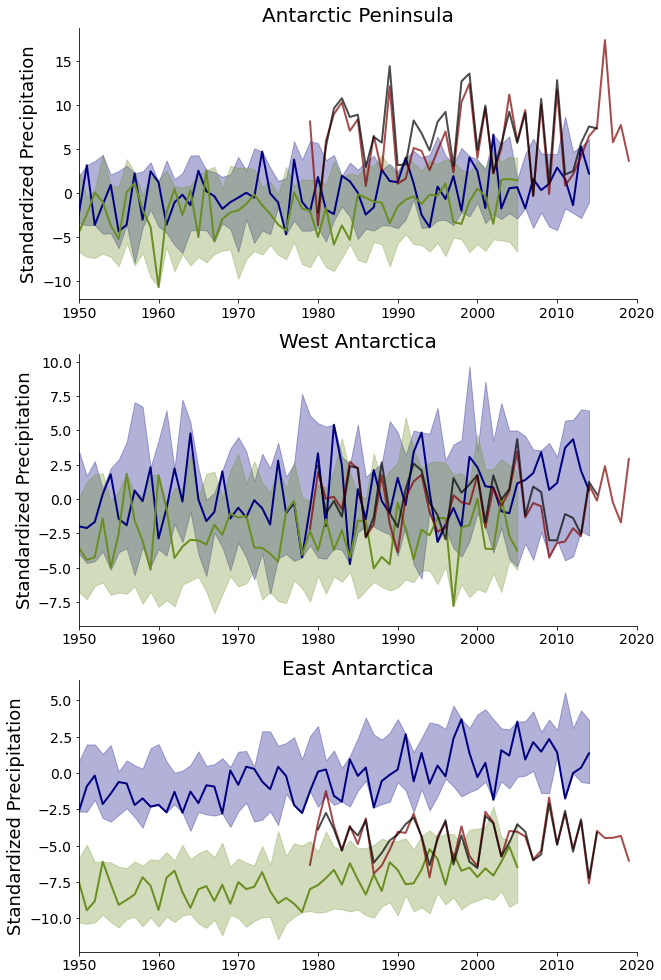

In [7]:
fig,ax = plt.subplots(3,1, figsize = (10,17))
plot_basin_timeseries(cesm2_pen/(10**12), cesm1_pen/(10**12), era_pen/(10**12), ax[0], 'Antarctic Peninsula', racmo = racmo_pen/(10**12))
plot_basin_timeseries(cesm2_west/(10**12), cesm1_west/(10**12), era_west/(10**12), ax[1], 'West Antarctica', racmo = racmo_west/(10**12))
plot_basin_timeseries(cesm2_east/(10**12), cesm1_east/(10**12), era_east/(10**12), ax[2], 'East Antarctica', racmo = racmo_east/(10**12))

plt.savefig('precip_by_basin.png')

## By season

In [11]:
def plot_season(era, cesm1, cesm2, ax, season):
    ax.plot(era.year, era, color = 'maroon', linewidth = 2)
    ax.plot(cesm1.year, cesm1.isel(ensemble = 0), color = 'olivedrab', linewidth = 2)
    ax.fill_between(cesm1.year, cesm1.min(dim='ensemble'), cesm1.max(dim='ensemble'), color = 'olivedrab', alpha = 0.3)
    ax.plot(cesm2.year, cesm2.isel(ensemble = 0), color = 'navy', linewidth = 2)
    ax.fill_between(cesm2.year, cesm2.min(dim='ensemble'), cesm2.max(dim='ensemble'), color = 'navy', alpha = 0.3)
    ax.set_xlim([1950,2021])
    ax.tick_params(labelsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(season, fontsize = 20)
    ax.set_ylabel('Total precip (Gt)', fontsize = 16)

In [12]:
#cesm2_precip.sel(cesm2_precip.time.dt.year = 2000)
cesm2_mam, cesm2_jja, cesm2_son, cesm2_djf = get_seasonal_data((cesm2_precip*cesm_area), 'sum')
cesm2_mam = cesm2_mam.sum(dim=['lat','lon'])/(10**12)
cesm2_jja = cesm2_jja.sum(dim=['lat','lon'])/(10**12)
cesm2_son = cesm2_son.sum(dim=['lat','lon'])/(10**12)
cesm2_djf = cesm2_djf.sum(dim=['lat','lon'])/(10**12)

cesm1_mam, cesm1_jja, cesm1_son, cesm1_djf = get_seasonal_data((cesm1_precip*cesm_area), 'sum')
cesm1_mam = cesm1_mam.sum(dim=['lat','lon'])/(10**12)
cesm1_jja = cesm1_jja.sum(dim=['lat','lon'])/(10**12)
cesm1_son = cesm1_son.sum(dim=['lat','lon'])/(10**12)
cesm1_djf = cesm1_djf.sum(dim=['lat','lon'])/(10**12)

era_mam, era_jja, era_son, era_djf = get_seasonal_data((era_precip*era_area), 'sum')
era_mam = era_mam.sum(dim=['latitude','longitude'])/(10**12)
era_jja = era_jja.sum(dim=['latitude','longitude'])/(10**12)
era_son = era_son.sum(dim=['latitude','longitude'])/(10**12)
era_djf = era_djf.sum(dim=['latitude','longitude'])/(10**12)

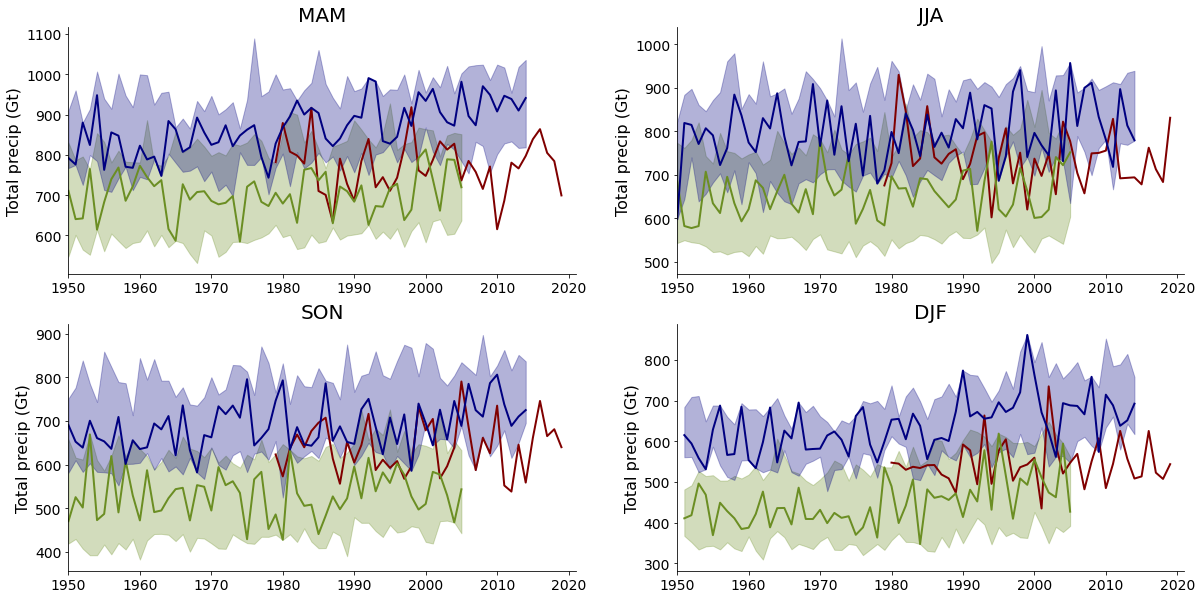

In [13]:
fig, ax = plt.subplots(2,2, figsize = (20,10))

plot_season(era_mam, cesm1_mam, cesm2_mam, ax[0,0], 'MAM')
plot_season(era_jja, cesm1_jja, cesm2_jja, ax[0,1], 'JJA')
plot_season(era_son, cesm1_son, cesm2_son, ax[1,0], 'SON')
plot_season(era_djf, cesm1_djf, cesm2_djf, ax[1,1], 'DJF')
plt.savefig('precip_by_season.png', dpi = 300)

## By basin and by season

In [5]:
cesm2_mam, cesm2_jja, cesm2_son, cesm2_djf = get_seasonal_data((cesm2_precip*cesm_area), 'sum')
cesm2_mam_pen, cesm2_mam_west, cesm2_mam_east = get_regions_series(cesm2_mam, cesm_masks, 'sum')
cesm2_jja_pen, cesm2_jja_west, cesm2_jja_east = get_regions_series(cesm2_jja, cesm_masks, 'sum')
cesm2_son_pen, cesm2_son_west, cesm2_son_east = get_regions_series(cesm2_son, cesm_masks, 'sum')
cesm2_djf_pen, cesm2_djf_west, cesm2_djf_east = get_regions_series(cesm2_djf, cesm_masks, 'sum')

cesm1_mam, cesm1_jja, cesm1_son, cesm1_djf = get_seasonal_data((cesm1_precip*cesm_area), 'sum')
cesm1_mam_pen, cesm1_mam_west, cesm1_mam_east = get_regions_series(cesm1_mam, cesm_masks, 'sum')
cesm1_jja_pen, cesm1_jja_west, cesm1_jja_east = get_regions_series(cesm1_jja, cesm_masks, 'sum')
cesm1_son_pen, cesm1_son_west, cesm1_son_east = get_regions_series(cesm1_son, cesm_masks, 'sum')
cesm1_djf_pen, cesm1_djf_west, cesm1_djf_east = get_regions_series(cesm1_djf, cesm_masks, 'sum')

era_mam, era_jja, era_son, era_djf = get_seasonal_data((era_precip*era_area), 'sum')
era_mam_pen, era_mam_west, era_mam_east = get_regions_series(era_mam, era_masks, 'sum', latcoord = 'latitude', loncoord = 'longitude')
era_jja_pen, era_jja_west, era_jja_east = get_regions_series(era_jja, era_masks, 'sum', latcoord = 'latitude', loncoord = 'longitude')
era_son_pen, era_son_west, era_son_east = get_regions_series(era_son, era_masks, 'sum', latcoord = 'latitude', loncoord = 'longitude')
era_djf_pen, era_djf_west, era_djf_east = get_regions_series(era_djf, era_masks, 'sum', latcoord = 'latitude', loncoord = 'longitude')

In [7]:
def get_trend_line(data):
    x = linregress(data.year, data.mean(dim = 'ensemble').values)
    slope = x.slope
    p = x.pvalue
    years = np.arange(1950, 2021)
    trend = slope * years + x.intercept
    
    trend_norm = (trend - data.mean().values)/data.mean(dim = 'ensemble').std().values
    return slope, p, trend_norm

In [8]:
jja_pen_s, jja_pen_p, jja_pen_trend = get_trend_line(cesm2_jja_pen/(10**12))
mam_pen_s, mam_pen_p, mam_pen_trend = get_trend_line(cesm2_mam_pen/(10**12))
son_pen_s, son_pen_p, son_pen_trend = get_trend_line(cesm2_son_pen/(10**12))
djf_pen_s, djf_pen_p, djf_pen_trend = get_trend_line(cesm2_djf_pen/(10**12))

jja_east_s, jja_east_p, jja_east_trend = get_trend_line(cesm2_jja_east/(10**12))
mam_east_s, mam_east_p, mam_east_trend = get_trend_line(cesm2_mam_east/(10**12))
son_east_s, son_east_p, son_east_trend = get_trend_line(cesm2_son_east/(10**12))
djf_east_s, djf_east_p, djf_east_trend = get_trend_line(cesm2_djf_east/(10**12))

jja_west_s, jja_west_p, jja_west_trend = get_trend_line(cesm2_jja_west/(10**12))
mam_west_s, mam_west_p, mam_west_trend = get_trend_line(cesm2_mam_west/(10**12))
son_west_s, son_west_p, son_west_trend = get_trend_line(cesm2_son_west/(10**12))
djf_west_s, djf_west_p, djf_west_trend = get_trend_line(cesm2_djf_west/(10**12))

years = np.arange(1950, 2021)

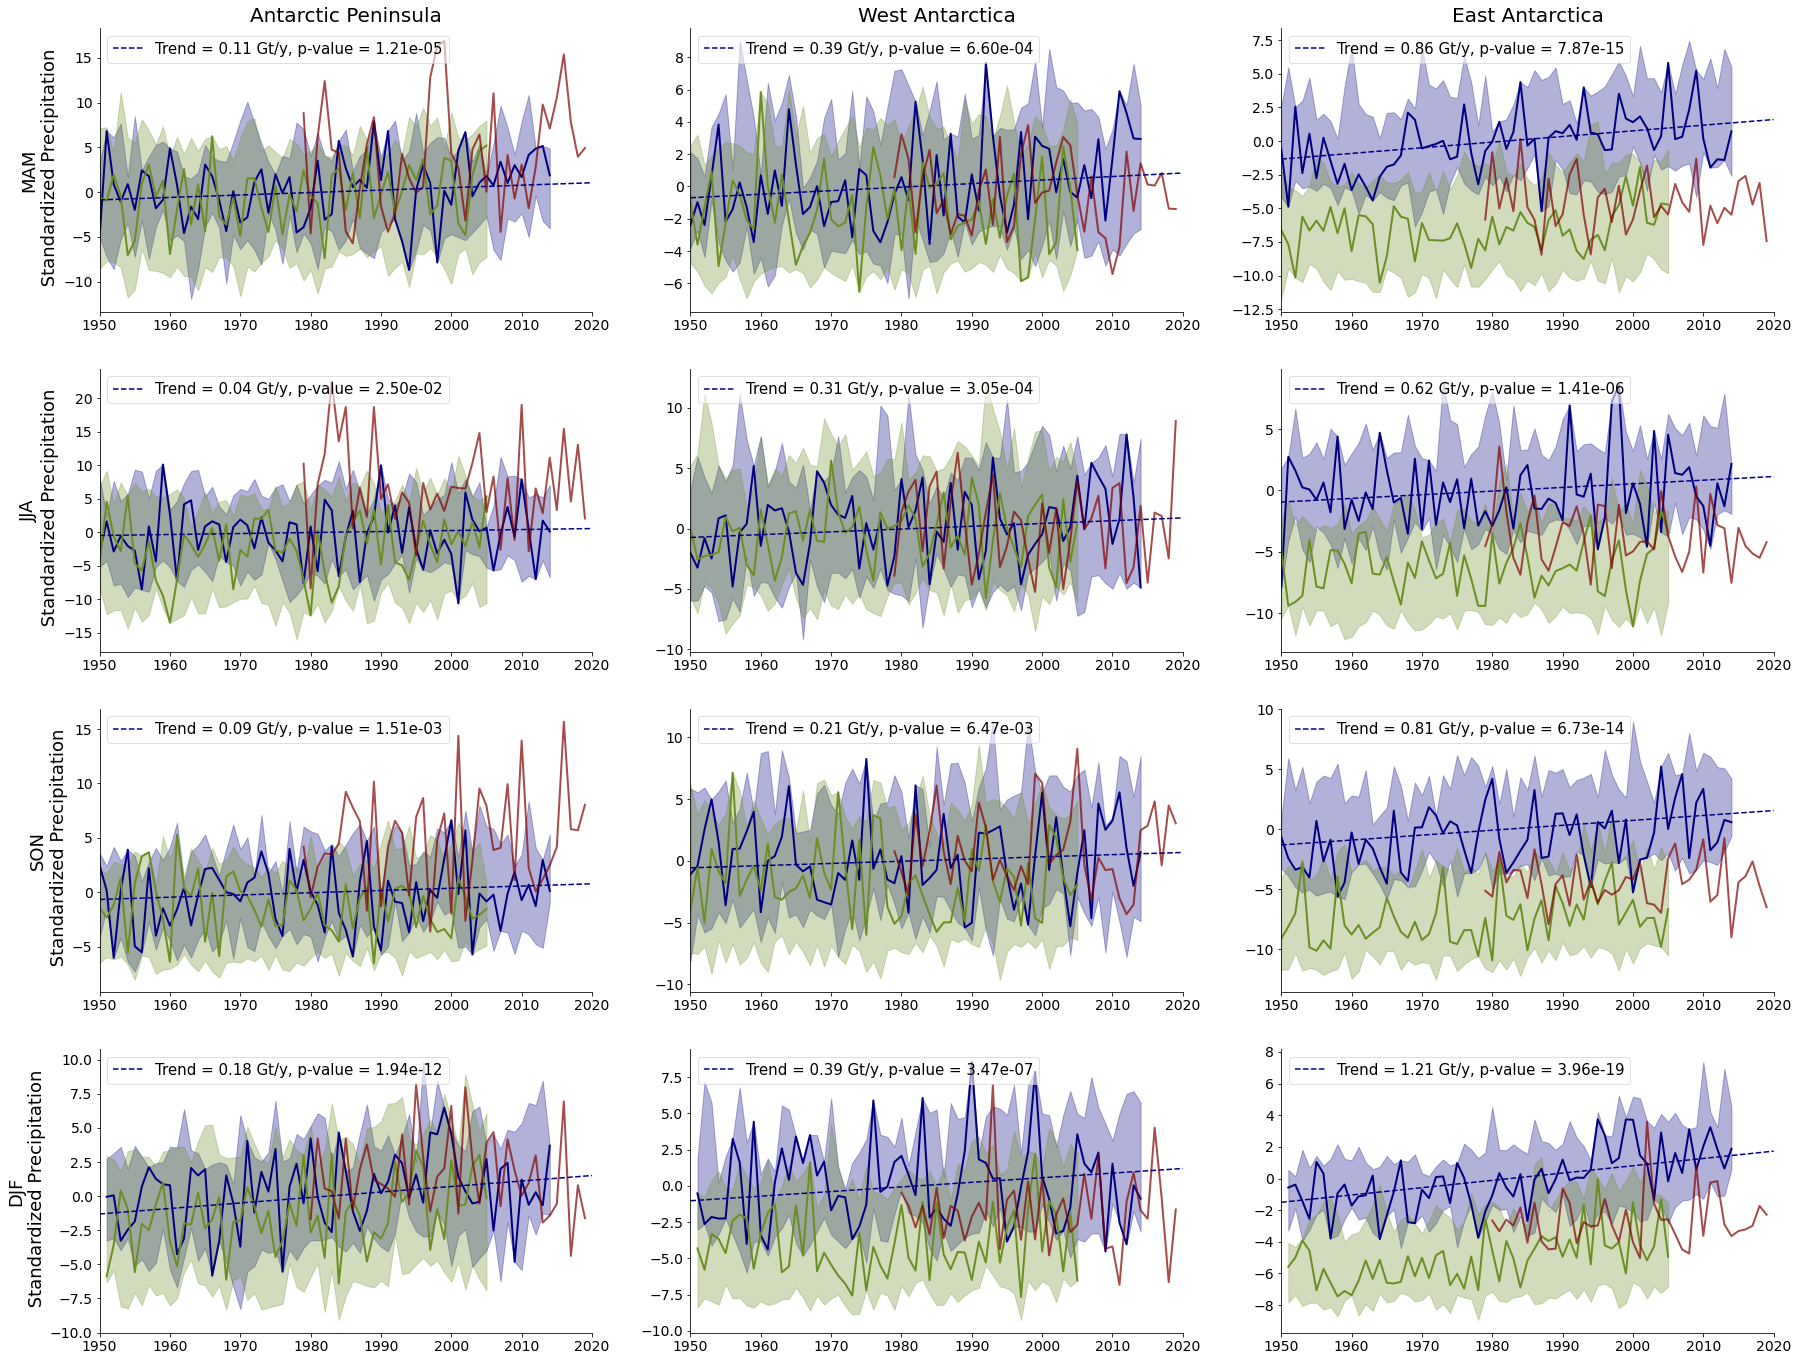

In [11]:
fig,ax = plt.subplots(4,3, figsize = (30,24))
plot_basin_timeseries(cesm2_mam_pen, cesm1_mam_pen, era_mam_pen, ax[0,0], 'Antarctic Peninsula')
ax[0,0].plot(years, mam_pen_trend, '--', color = 'navy', label = f'Trend = {mam_pen_s:0.2f} Gt/y, p-value = {mam_pen_p:0.2e}')
ax[0,0].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_jja_pen, cesm1_jja_pen, era_jja_pen, ax[1,0], '')
ax[1,0].plot(years, jja_pen_trend, '--', color = 'navy', label = f'Trend = {jja_pen_s:0.2f} Gt/y, p-value = {jja_pen_p:0.2e}')
ax[1,0].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_son_pen, cesm1_son_pen, era_son_pen, ax[2,0], '')
ax[2,0].plot(years, son_pen_trend, '--', color = 'navy', label = f'Trend = {son_pen_s:0.2f} Gt/y, p-value = {son_pen_p:0.2e}')
ax[2,0].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_djf_pen, cesm1_djf_pen, era_djf_pen, ax[3,0], '')
ax[3,0].plot(years, djf_pen_trend, '--', color = 'navy', label = f'Trend = {djf_pen_s:0.2f} Gt/y, p-value = {djf_pen_p:0.2e}')
ax[3,0].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})

plot_basin_timeseries(cesm2_mam_west, cesm1_mam_west, era_mam_west, ax[0,1], 'West Antarctica')
ax[0,1].plot(years, mam_west_trend, '--', color = 'navy', label = f'Trend = {mam_west_s:0.2f} Gt/y, p-value = {mam_west_p:0.2e}')
ax[0,1].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_jja_west, cesm1_jja_west, era_jja_west, ax[1,1], '')
ax[1,1].plot(years, jja_west_trend, '--', color = 'navy', label = f'Trend = {jja_west_s:0.2f} Gt/y, p-value = {jja_west_p:0.2e}')
ax[1,1].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_son_west, cesm1_son_west, era_son_west, ax[2,1], '')
ax[2,1].plot(years, son_west_trend, '--', color = 'navy', label = f'Trend = {son_west_s:0.2f} Gt/y, p-value = {son_west_p:0.2e}')
ax[2,1].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_djf_west, cesm1_djf_west, era_djf_west, ax[3,1], '')
ax[3,1].plot(years, djf_west_trend, '--', color = 'navy', label = f'Trend = {djf_west_s:0.2f} Gt/y, p-value = {djf_west_p:0.2e}')
ax[3,1].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})

plot_basin_timeseries(cesm2_mam_east, cesm1_mam_east, era_mam_east, ax[0,2], 'East Antarctica')
ax[0,2].plot(years, mam_east_trend, '--', color = 'navy', label = f'Trend = {mam_east_s:0.2f} Gt/y, p-value = {mam_east_p:0.2e}')
ax[0,2].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_jja_east, cesm1_jja_east, era_jja_east, ax[1,2], '')
ax[1,2].plot(years, jja_east_trend, '--', color = 'navy', label = f'Trend = {jja_east_s:0.2f} Gt/y, p-value = {jja_east_p:0.2e}')
ax[1,2].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_son_east, cesm1_son_east, era_son_east, ax[2,2], '')
ax[2,2].plot(years, son_east_trend, '--', color = 'navy', label = f'Trend = {son_east_s:0.2f} Gt/y, p-value = {son_east_p:0.2e}')
ax[2,2].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})
plot_basin_timeseries(cesm2_djf_east, cesm1_djf_east, era_djf_east, ax[3,2], '')
ax[3,2].plot(years, djf_east_trend, '--', color = 'navy', label = f'Trend = {djf_east_s:0.2f} Gt/y, p-value = {djf_east_p:0.2e}')
ax[3,2].legend(loc = 'upper left', facecolor = 'white', framealpha=0.6, prop={'size': 15})

ax[0,0].set_ylabel('MAM\n Standardized Precipitation')
ax[1,0].set_ylabel('JJA\n Standardized Precipitation')
ax[2,0].set_ylabel('SON\n Standardized Precipitation')
ax[3,0].set_ylabel('DJF\n Standardized Precipitation')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')
ax[0,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,2].set_ylabel('')
ax[2,2].set_ylabel('')
ax[3,2].set_ylabel('')

plt.savefig('precip_by_basin_and_season.png', dpi = 300)

## Seasonality

In [12]:
cesm2_subset = (cesm2_precip*cesm_area).sel(time = slice('1980-01-01', '2005-12-31'))
cesm2_seasonality = cesm2_subset.groupby(cesm2_subset.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

cesm1_subset = (cesm1_precip*cesm_area).sel(time = slice('1980-01-01', '2005-12-31'))
cesm1_seasonality = cesm1_subset.groupby(cesm1_subset.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

era_subset = (era_precip*era_area).sel(time = slice('1980-01-01', '2005-12-31'))
era_seasonality = era_subset.groupby(era_subset.time.dt.month).mean().sum(dim = ['latitude', 'longitude'])/(10**12)


/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


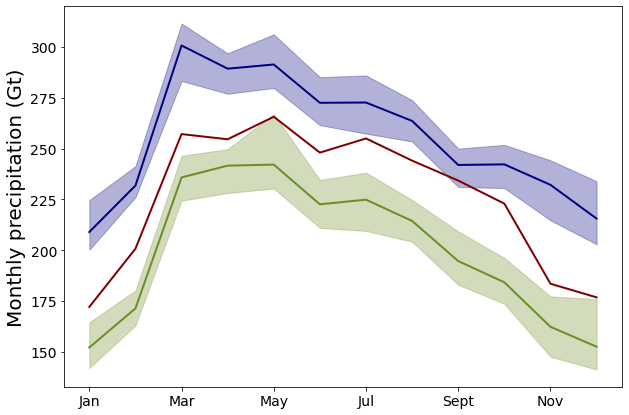

In [13]:
fig,ax = plt.subplots(1,1, figsize = (10,7))

ax.plot(cesm2_seasonality.month, cesm2_seasonality.mean(dim = 'ensemble'), color = 'navy', linewidth = 2)
ax.fill_between(cesm2_seasonality.month,cesm2_seasonality.min(dim = 'ensemble'), cesm2_seasonality.max(dim = 'ensemble'), color = 'navy', alpha = 0.3)

ax.plot(cesm1_seasonality.month, cesm1_seasonality.mean(dim = 'ensemble'), color = 'olivedrab', linewidth = 2)
ax.fill_between(cesm1_seasonality.month,cesm1_seasonality.min(dim = 'ensemble'), cesm1_seasonality.max(dim = 'ensemble'), color = 'olivedrab', alpha = 0.3)

ax.plot(era_seasonality.month, era_seasonality, color = 'maroon', linewidth = 2)

ax.set_xticks([1,3,5,7,9,11])
ax.set_xticklabels(['Jan', 'Mar', 'May', 'Jul', 'Sept', 'Nov'], fontsize = 14);
ax.tick_params(labelsize=14)
ax.set_ylabel('Monthly precipitation (Gt)', fontsize = 20)
#plt.legend(prop={"size":16})
plt.savefig('precip_seasonality.png', dpi = 300)


## Ice shelves

In [14]:
cesm_shelf_mask = xr.open_dataset('/glade/work/devond/AIS_masks/iceshelfmask_CESM2.nc')
cesm_shelf_mask = cesm_shelf_mask.sel(latitude = slice(-90,-60))

era_grounded =  np.copy(era_masks.grounded_ism.values)
era_grounded[np.isnan(era_grounded)] = 0
era_shelf_mask = era_masks.full_ism.values - era_grounded

racmo_grounded =  np.copy(racmo_masks.grounded_ism.values)
racmo_grounded[np.isnan(racmo_grounded)] = 0
racmo_shelf_mask = racmo_masks.full_ism.values - racmo_grounded

In [15]:
#ice shelf precip
cesm2_shelf_precip = cesm2_precip * cesm_shelf_mask.ism.values *cesm_area
cesm2_shelf_precip = cesm2_shelf_precip.groupby(cesm2_shelf_precip.time.dt.year).sum()
cesm2_shelf_precip = cesm2_shelf_precip.sum(dim = ['lat', 'lon'])/(10**12)

cesm1_shelf_precip = cesm1_precip * cesm_shelf_mask.ism.values *cesm_area
cesm1_shelf_precip = cesm1_shelf_precip.groupby(cesm1_shelf_precip.time.dt.year).sum()
cesm1_shelf_precip = cesm1_shelf_precip.sum(dim = ['lat', 'lon'])/(10**12)

era_shelf_precip = era_precip * era_shelf_mask * era_area
era_shelf_precip = era_shelf_precip.groupby(era_shelf_precip.time.dt.year).sum()
era_shelf_precip = era_shelf_precip.sum(dim = ['latitude', 'longitude'])/(10**12)

racmo_shelf_precip = racmo_precip * racmo_shelf_mask * racmo_area
racmo_shelf_precip = racmo_shelf_precip.sum(dim = ['rlat', 'rlon'])/(10**12)

In [16]:
#grounded ice sheet precip
cesm2_grounded_precip = cesm2_precip * cesm_masks.grounded_ism.values *cesm_area
cesm2_grounded_precip = cesm2_grounded_precip.groupby(cesm2_grounded_precip.time.dt.year).sum()
cesm2_grounded_precip = cesm2_grounded_precip.sum(dim = ['lat', 'lon'])/(10**12)

cesm1_grounded_precip = cesm1_precip * cesm_masks.grounded_ism.values*cesm_area
cesm1_grounded_precip = cesm1_grounded_precip.groupby(cesm1_grounded_precip.time.dt.year).sum()
cesm1_grounded_precip = cesm1_grounded_precip.sum(dim = ['lat', 'lon'])/(10**12)

era_grounded_precip = era_precip * era_masks.grounded_ism.values*era_area
era_grounded_precip = era_grounded_precip.groupby(era_grounded_precip.time.dt.year).sum()
era_grounded_precip = era_grounded_precip.sum(dim = ['latitude', 'longitude'])/(10**12)

racmo_grounded_precip = racmo_precip * racmo_masks.grounded_ism.values * racmo_area
racmo_grounded_precip = racmo_grounded_precip.sum(dim = ['rlat', 'rlon'])/(10**12)

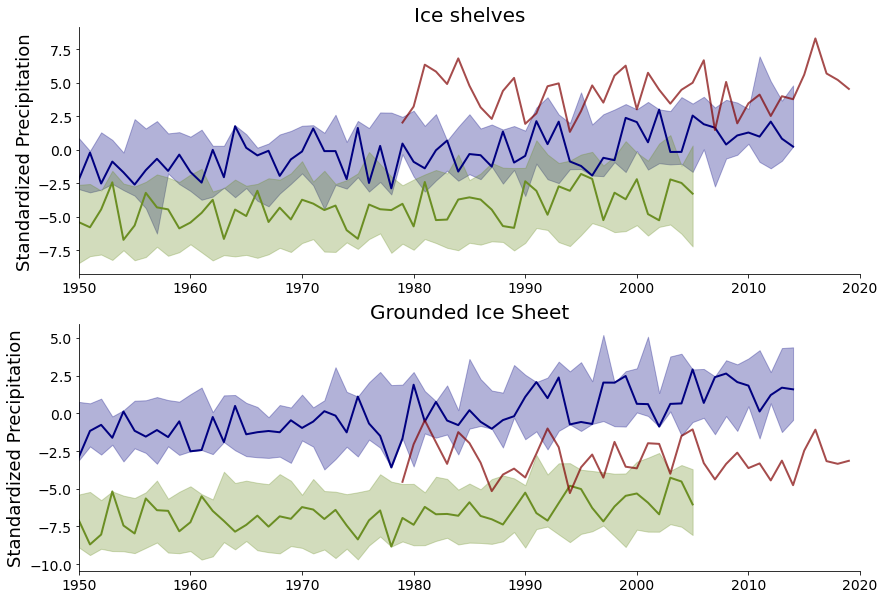

In [18]:
fig, ax = plt.subplots(2,1,figsize = (14,10))

plot_basin_timeseries(cesm2_shelf_precip, cesm1_shelf_precip, era_shelf_precip, ax[0], 'Ice shelves')
plot_basin_timeseries(cesm2_grounded_precip, cesm1_grounded_precip, era_grounded_precip,ax[1], 'Grounded Ice Sheet')
plt.savefig('ice_shelf_precip.png', dpi = 300)

## Rainfall

In [19]:
### -----  CESM2  ----- ###
cesm2_rain = cesm2_rain * cesm_ism * cesm_area
cesm2_rain = (cesm2_rain*3600*24*cesm2_rain.time.dt.days_in_month)
cesm2_rain = cesm2_rain.groupby(cesm2_rain.time.dt.year).sum()
cesm2_rain = cesm2_rain.sum(dim = ['lat', 'lon'])/(10**12)

### -----  CESM1  ----- ###
cesm1_rain = cesm1_rain * cesm_ism * cesm_area
cesm1_rain = (cesm1_rain*3600*24*cesm1_rain.time.dt.days_in_month)
cesm1_rain = cesm1_rain.groupby(cesm1_rain.time.dt.year).sum()
cesm1_rain = cesm1_rain.sum(dim = ['lat', 'lon'])/(10**12)

### -----  ERA  ----- ###
era_rain = data['tp'] - data['sf']
era_rain = era_rain * era_ism * era_area
era_rain = (era_rain*(10**3)*era_precip.time.dt.days_in_month)
era_rain = era_rain.groupby(era_rain.time.dt.year).sum()
era_rain = era_rain.sum(dim = ['latitude', 'longitude'])/(10**12)


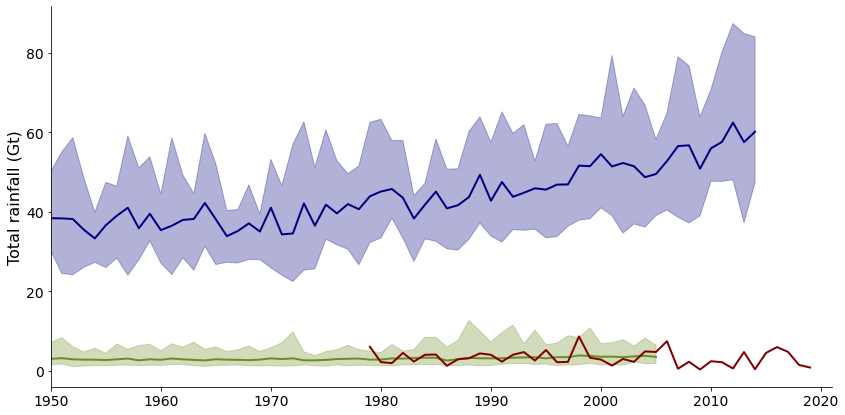

In [20]:
fig, ax = plt.subplots(1,1,figsize = (14,7))
plt.plot(cesm2_rain.year, cesm2_rain.mean(dim = 'ensemble'), color = 'navy', linewidth = 2)
plt.fill_between(cesm2_rain.year, cesm2_rain.min(dim = 'ensemble'), cesm2_rain.max(dim = 'ensemble'), color = 'navy', alpha = 0.3)
plt.plot(cesm1_rain.year, cesm1_rain.mean(dim = 'ensemble'), color = 'olivedrab', linewidth = 2)
plt.fill_between(cesm1_rain.year, cesm1_rain.min(dim = 'ensemble'), cesm1_rain.max(dim = 'ensemble'), color = 'olivedrab', alpha = 0.3)
plt.plot(era_rain.year, era_rain, color = 'maroon', linewidth = 2)
ax.set_xlim([1950,2021])
ax.tick_params(labelsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Total rainfall (Gt)', fontsize = 16)
plt.savefig('raingall.png', dpi = 300)

## Annual precip trends

In [20]:
cesm2_precip_emean = cesm2_precip.sel(time = slice('1979-01-01','2015-01-01')).mean(dim='ensemble')
cesm2_precip_amean = cesm2_precip_emean.groupby(cesm2_precip_emean.time.dt.year).sum()
cesm2_trend, cesm2_p = calculate_trend(cesm2_precip_amean.values)
cesm2_trend2, lon2 = add_cyclic_point(cesm2_trend, coord=lon)
cesm2_sig = np.copy(cesm2_p)
cesm2_sig[cesm2_sig>0.05] = np.nan

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [19]:
cesm1_precip_emean = cesm1_precip.sel(time = slice('1979-01-01','2015-01-01')).mean(dim='ensemble')
cesm1_precip_amean = cesm1_precip_emean.groupby(cesm1_precip_emean.time.dt.year).sum()
cesm1_trend, cesm1_p = calculate_trend(cesm1_precip_amean.values)
cesm1_trend2, lon2 = add_cyclic_point(cesm1_trend, coord=lon)
cesm1_sig = np.copy(cesm1_p)
cesm1_sig[cesm1_sig>0.05] = np.nan

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [22]:
era = xr.open_dataset('/glade/work/devond/ERA5/all.nc')
era = era.sel(latitude = slice(-60, -90))
era_masks = xr.open_dataset('/glade/work/devond/AIS_masks/model_masks/ERA_masks.nc')
era_masks = era_masks.sel(lat = slice(-60, -90))
era_ism = era_masks.full_ism.values
era_ism[era_ism==0]=np.nan
era_lat = era_masks.lat
era_lon = era_masks.lon

era_precip = era['tp']*era_ism*(10**3)
era_precip = era_precip*era_precip.time.dt.days_in_month #mwe to mmwe = kg/m2 
era_precip_annual = era_precip.groupby(era_precip.time.dt.year).sum()

era_trend, era_p = calculate_trend(era_precip_annual*era_ism)
era_sig = np.copy(era_p)
era_sig[era_sig>0.05] = np.nan

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [26]:
era_trend

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.0109111 ,  0.01153646,  0.00979811, ...,  0.01333035,
         0.01118216,  0.01084   ],
       [-0.01393354, -0.01381991, -0.01309848, ..., -0.01282983,
        -0.01341689, -0.01387786],
       [-0.04111851, -0.04111851, -0.04111851, ..., -0.04111851,
        -0.04111851, -0.04111851]])

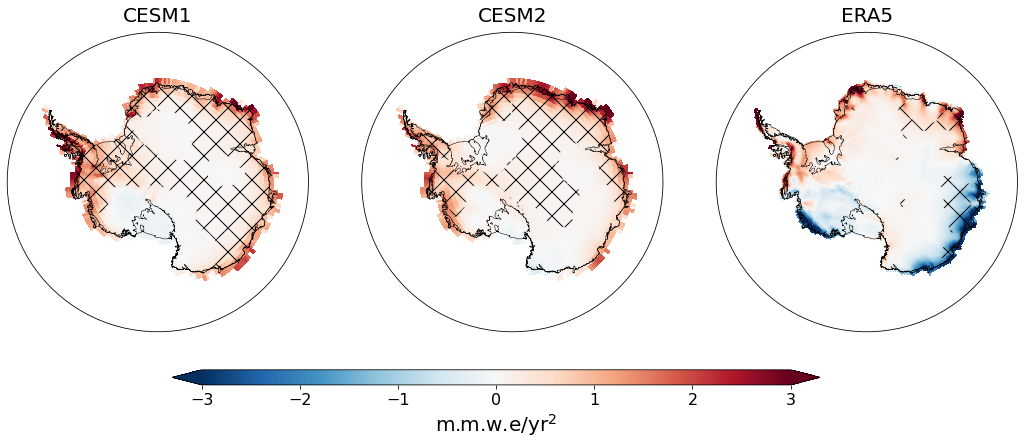

In [42]:
fig = plt.figure(figsize = (18,7))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon2, cesm2_precip.lat, cesm1_trend2,transform = crs_ll, cmap = 'RdBu_r',vmin = -3, vmax = 3)
ax1.contourf(cesm2_precip.lon, cesm2_precip.lat, cesm1_sig, hatches=['x'],transform = crs_ll, alpha=0)
ax1.set_title('CESM1', fontsize = 20)

ax2 = plt.subplot(gs[1],projection=crs_sp)
plot_antarctica(ax2,-60)
im = ax2.pcolormesh(lon2, cesm2_precip.lat, cesm2_trend2,transform = crs_ll, cmap = 'RdBu_r', vmin = -3, vmax = 3)
ax2.contourf(cesm2_precip.lon, cesm2_precip.lat, cesm2_sig, hatches=['x'],transform = crs_ll, alpha=0)
ax2.set_title('CESM2', fontsize = 20)

ax3 = plt.subplot(gs[2],projection=crs_sp)
plot_antarctica(ax3,-60)
im2 = ax3.pcolormesh(era_precip['longitude'], era_precip['latitude'], era_trend ,transform = crs_ll, cmap = 'RdBu_r', vmin = -3, vmax = 3)
ax3.contourf(era_precip['longitude'], era_precip['latitude'], era_sig, hatches=['x'],transform = crs_ll, alpha=0)
ax3.set_title('ERA5', fontsize = 20)

    #fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label=f'm.m.w.e/yr$^2$', size=20)
cb.ax.tick_params(labelsize=16)


plt.savefig('annual_precip_trend.png', dpi = 300, bbox_inches = 'tight', transparent = True)

In [41]:
np.nansum(era_trend * era_masks.area.values)/(np.nansum(era_masks.area.values*era_ism))

-0.04193269802555742

## Precip trends

In [24]:
cesm2_precip_emean = cesm2_precip.sel(time = slice('1979-01-01','2015-01-01')).mean(dim='ensemble')
cesm2_precip_mam, cesm2_precip_jja, cesm2_precip_son, cesm2_precip_djf = get_seasonal_data(cesm2_precip_emean, 'sum')
cesm2_precip_mam_norm = (cesm2_precip_mam - cesm2_precip_mam.mean(dim = 'year'))/cesm2_precip_mam.std(dim = 'year')
cesm2_precip_jja_norm = (cesm2_precip_jja - cesm2_precip_jja.mean(dim = 'year'))/cesm2_precip_jja.std(dim = 'year')
cesm2_precip_son_norm = (cesm2_precip_son - cesm2_precip_son.mean(dim = 'year'))/cesm2_precip_son.std(dim = 'year')
cesm2_precip_djf_norm = (cesm2_precip_djf - cesm2_precip_djf.mean(dim = 'year'))/cesm2_precip_djf.std(dim = 'year')

djf_trend, djf_p = calculate_trend(cesm2_precip_djf.values)
mam_trend, mam_p = calculate_trend(cesm2_precip_mam.values)
jja_trend, jja_p = calculate_trend(cesm2_precip_jja.values)
son_trend, son_p = calculate_trend(cesm2_precip_son.values)

djf_trend_norm, djf_p_norm = calculate_trend(cesm2_precip_djf_norm.values)
mam_trend_norm, mam_p_norm = calculate_trend(cesm2_precip_mam_norm.values)
jja_trend_norm, jja_p_norm = calculate_trend(cesm2_precip_jja_norm.values)
son_trend_norm, son_p_norm = calculate_trend(cesm2_precip_son_norm.values)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [25]:
#get rid of white space for plot
djf_trend, lon2 = add_cyclic_point(djf_trend, coord=lon)
djf_p_norm, lon2 = add_cyclic_point(djf_p_norm, coord=lon)
djf_trend_norm, lon2 = add_cyclic_point(djf_trend_norm, coord=lon)

mam_trend, lon2 = add_cyclic_point(mam_trend, coord=lon)
mam_p_norm, lon2 = add_cyclic_point(mam_p_norm, coord=lon)
mam_trend_norm, lon2 = add_cyclic_point(mam_trend_norm, coord=lon)

son_trend, lon2 = add_cyclic_point(son_trend, coord=lon)
son_p_norm, lon2 = add_cyclic_point(son_p_norm, coord=lon)
son_trend_norm, lon2 = add_cyclic_point(son_trend_norm, coord=lon)

jja_trend, lon2 = add_cyclic_point(jja_trend, coord=lon)
jja_p_norm, lon2 = add_cyclic_point(jja_p_norm, coord=lon)
jja_trend_norm, lon2 = add_cyclic_point(jja_trend_norm, coord=lon)

In [26]:
djf_sig = np.copy(djf_trend_norm)
djf_sig[djf_p_norm>0.05] = np.nan

jja_sig = np.copy(jja_trend_norm)
jja_sig[jja_p_norm>0.05] = np.nan

mam_sig = np.copy(mam_trend_norm)
mam_sig[mam_p_norm>0.05] = np.nan

son_sig = np.copy(son_trend_norm)
son_sig[son_p_norm>0.05] = np.nan

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [14]:
era = xr.open_dataset('/glade/work/devond/ERA5/all.nc')
era = era.sel(latitude = slice(-60, -90))
era = era.sel(time = slice('1979-01-01','2015-01-01'))
era_masks = xr.open_dataset('/glade/work/devond/AIS_masks/model_masks/ERA_masks.nc')
era_masks = era_masks.sel(lat = slice(-60, -90))
era_ism = era_masks.full_ism.values
era_ism[era_ism==0]=np.nan
era_lat = era_masks.lat
era_lon = era_masks.lon

era_precip = era['tp']*era_ism*(10**3)
era_precip = era_precip*era_precip.time.dt.days_in_month #mwe to mmwe = kg/m2 
era_precip_mam, era_precip_jja, era_precip_son, era_precip_djf = get_seasonal_data(era_precip, 'sum')

era_trend_mam, mam_p = calculate_trend(era_precip_mam*era_ism)
era_trend_jja, jja_p = calculate_trend(era_precip_jja*era_ism)
era_trend_son, son_p = calculate_trend(era_precip_son*era_ism)
era_trend_djf, djf_p = calculate_trend(era_precip_djf*era_ism)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
ds = xr.Dataset(
    data_vars=dict(
        trend=(["lat", "lon"], djf_trend_norm),
        significant=(["lat", "lon"], djf_sig),
    ),
    coords=dict(
        lon=lon2,
        lat=lat,
    ),
)

In [28]:
ds = convert_lon(ds)
ds.to_netcdf('cesm_djf_trend.nc')

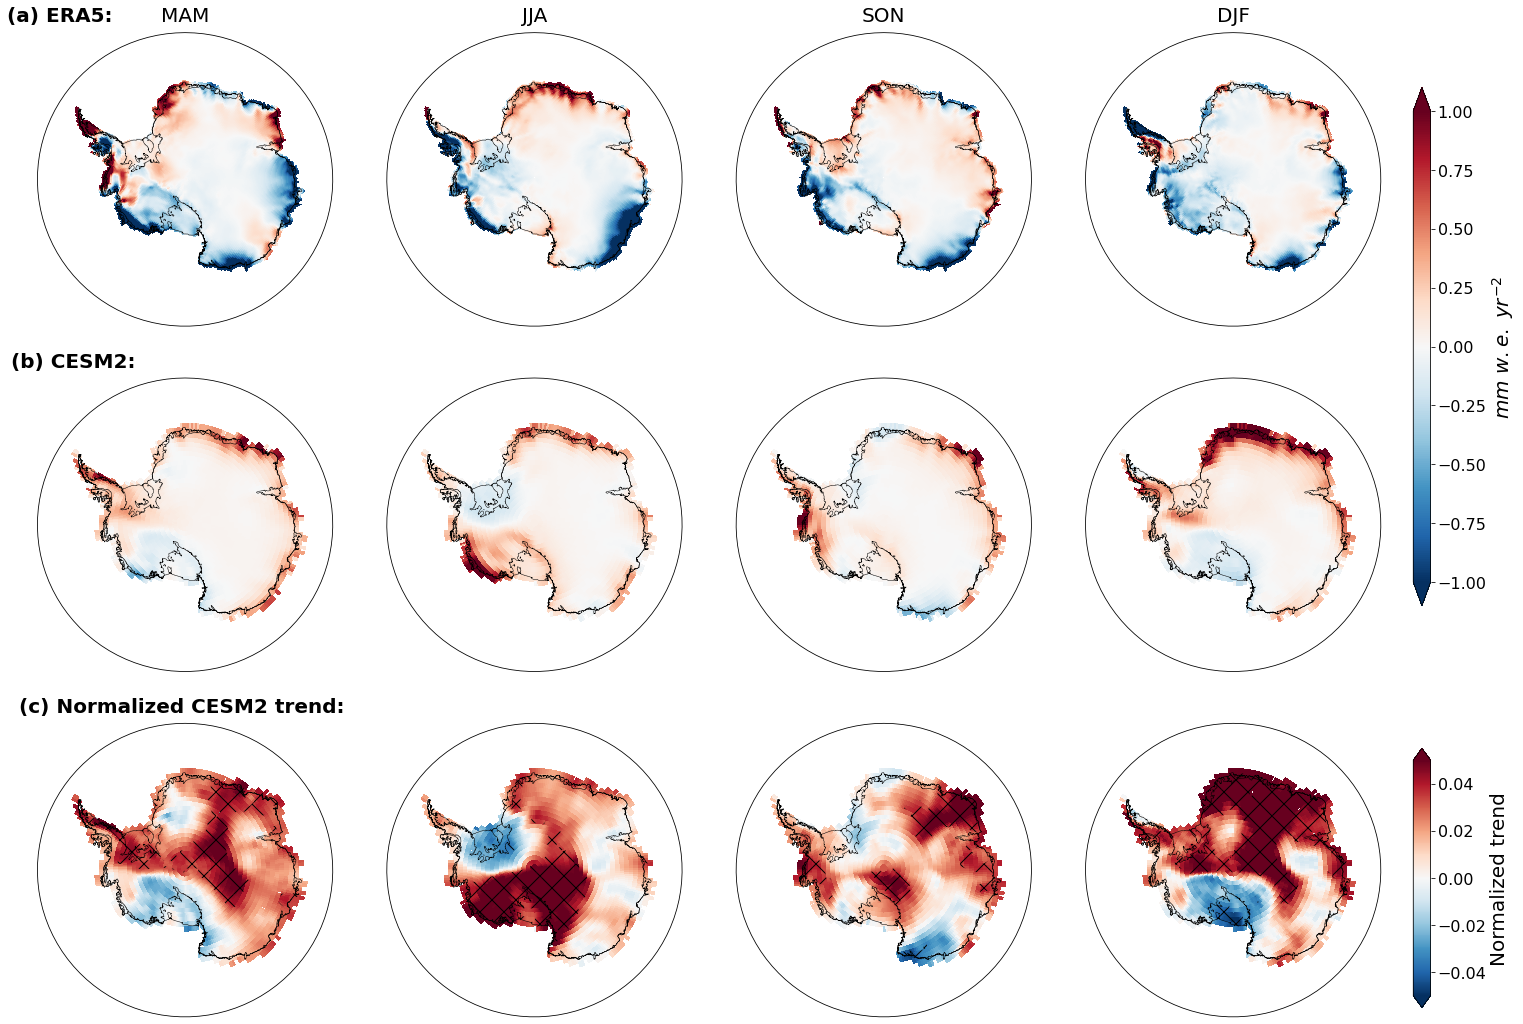

In [16]:
fig = plt.figure(figsize = (24,18))
gs=GridSpec(3,4)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax2 = plt.subplot(gs[0,1],projection=crs_sp)
ax3 = plt.subplot(gs[0,2],projection=crs_sp)
ax4 = plt.subplot(gs[0,3],projection=crs_sp)
im = plot_seasonal_plots(era_lat,era_lon, era_trend_mam*era_ism, era_trend_jja*era_ism, era_trend_son*era_ism, era_trend_djf*era_ism, 'RdBu_r', -1, 1, [ax1, ax2, ax3, ax4], -60)
ax1.set_title('MAM', fontsize = 20)
ax1.text(0.25, 1.1, '(a) ERA5:', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax2.set_title('JJA', fontsize = 20)
ax3.set_title('SON', fontsize = 20)
ax4.set_title('DJF', fontsize = 20)

ax5 = plt.subplot(gs[1,0],projection=crs_sp)
ax6 = plt.subplot(gs[1,1],projection=crs_sp)
ax7 = plt.subplot(gs[1,2],projection=crs_sp)
ax8 = plt.subplot(gs[1,3],projection=crs_sp)
im = plot_seasonal_plots(lat,lon2, mam_trend, jja_trend, son_trend, djf_trend, 'RdBu_r', -1, 1, [ax5, ax6, ax7, ax8], -60)
ax5.text(0.33, 1.1, '(b) CESM2:', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax9 = plt.subplot(gs[2,0],projection=crs_sp)
ax10 = plt.subplot(gs[2,1],projection=crs_sp)
ax11 = plt.subplot(gs[2,2],projection=crs_sp)
ax12 = plt.subplot(gs[2,3],projection=crs_sp)
im2 = plot_seasonal_plots(lat,lon2, mam_trend_norm, jja_trend_norm, son_trend_norm, djf_trend_norm, 'RdBu_r', -0.05, 0.05, [ax9, ax10, ax11,ax12], -60, sig = [mam_sig, jja_sig, son_sig, djf_sig])
ax9.text(1.05, 1.1, '(c) Normalized CESM2 trend:', transform=ax9.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

cbar_ax = fig.add_axes([0.92, 0.44, 0.01, 0.4])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label='$mm~w.e.~yr^{-2}$', size=20)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.92, 0.13, 0.01, 0.2])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label=f'Normalized trend', size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig('precipitation_trends.png', dpi = 300, bbox_inches = 'tight')

In [33]:
basin1 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin1.nc')
basin1 = basin1.sel(lat = slice(-90,-60)).Zwallybasins
basin18 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin18.nc')
basin18 = basin18.sel(lat = slice(-90,-60)).Zwallybasins
basin19 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin19.nc')
basin19 = basin19.sel(lat = slice(-90,-60)).Zwallybasins
basin20 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin20.nc')
basin20 = basin20.sel(lat = slice(-90,-60)).Zwallybasins
basin21 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin21.nc')
basin21 = basin21.sel(lat = slice(-90,-60)).Zwallybasins
basin22 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin22.nc')
basin22 = basin22.sel(lat = slice(-90,-60)).Zwallybasins
basin23 = xr.open_dataset('/glade/work/devond/AIS_masks/basin_masks/AIS_Fullbasins_Zwally_CESMgrid_basin23.nc')
basin23 = basin23.sel(lat = slice(-90,-60)).Zwallybasins

mask_east = (basin18+basin19).values
mask_east[mask_east==0]=np.nan
mask_west = (basin1+basin22+basin23).values
mask_west[mask_west==0]=np.nan

In [34]:
cesm2_precip_emean = cesm2_precip.sel(time = slice('1979-01-01','2015-01-01')).mean(dim='ensemble')
cesm2_precip_djf_temp = cesm2_precip_emean.sel(time=cesm2_precip_emean['time.season']=='DJF')
cesm2_precip_djf_temp = fix_time(cesm2_precip_djf_temp)
cesm2_precip_djf_temp = cesm2_precip_djf_temp.groupby(cesm2_precip_djf_temp.time.dt.year).sum()

cesm2_west1 = (cesm2_precip_djf_temp * mask_east * cesm_area).sum(dim = ['lat','lon'])/10**12
cesm2_west2 = (cesm2_precip_djf_temp * mask_west * cesm_area).sum(dim = ['lat','lon'])/10**12

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


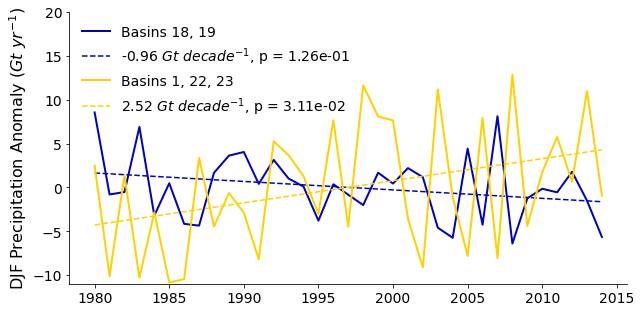

In [36]:
trend1 = linregress(cesm2_west1.year, cesm2_west1)
line1 = cesm2_west1.year * trend1.slope+trend1.intercept - cesm2_west1.mean()
trend2 = linregress(cesm2_west2.year, cesm2_west2)
line2 = cesm2_west2.year * trend2.slope+trend2.intercept - cesm2_west2.mean()

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(cesm2_west1.year, (cesm2_west1- cesm2_west1.mean()), color = '#0003ba', linewidth = 2, label = 'Basins 18, 19')
ax.plot(cesm2_west1.year, line1,'--', color = '#0003ba', label = f'{trend1.slope*10:0.2f}' + ' $Gt~decade^{-1}$' +f', p = {trend1.pvalue:0.2e}')
ax.plot(cesm2_west2.year, (cesm2_west2- cesm2_west2.mean()),color = '#ffd101', linewidth = 2, label = 'Basins 1, 22, 23')
plt.plot(cesm2_west2.year, line2,'--',color = '#ffd101', label = f'{trend2.slope*10:0.2f}' + ' $Gt~decade^{-1}$' +f', p = {trend2.pvalue:0.2e}')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=14)
ax.set_ylabel('DJF Precipitation Anomaly ($Gt~yr^{-1}$)', fontsize=16)
ax.legend(frameon = False, prop={'size':14})
ax.set_ylim([-11,20])


plt.savefig('DJF_West_precip.png', dpi = 300, bbox_inches = 'tight')



In [58]:
era = xr.open_dataset('/glade/work/devond/ERA5/all.nc')
era = era.sel(latitude = slice(-60, -90))
era_masks = xr.open_dataset('/glade/work/devond/AIS_masks/model_masks/ERA_masks.nc')
era_masks = era_masks.sel(lat = slice(-60, -90))
era_ism = era_masks.full_ism.values
era_ism[era_ism==0]=np.nan
era_lat = era_masks.lat
era_lon = era_masks.lon

era_precip = era['tp']*era_ism*(10**3)
era_precip = era_precip*era_precip.time.dt.days_in_month #mwe to mmwe = kg/m2 
era_precip_mam, era_precip_jja, era_precip_son, era_precip_djf = get_seasonal_data(era_precip, 'sum')

era_trend_mam, mam_p = calculate_trend(era_precip_mam*era_ism)
era_trend_jja, jja_p = calculate_trend(era_precip_jja*era_ism)
era_trend_son, son_p = calculate_trend(era_precip_son*era_ism)
era_trend_djf, djf_p = calculate_trend(era_precip_djf*era_ism)

In [92]:
cesm2_precip_emean_lon = convert_lon(cesm2_precip_emean)
cesm2_precip_mam2, cesm2_precip_jja2, cesm2_precip_son2, cesm2_precip_djf2 = get_seasonal_data(cesm2_precip_emean_lon, 'sum')

djf_trend2, djf_p2 = calculate_trend(cesm2_precip_djf2.values)
mam_trend2, mam_p2 = calculate_trend(cesm2_precip_mam2.values)
jja_trend2, jja_p2 = calculate_trend(cesm2_precip_jja2.values)
son_trend2, son_p2 = calculate_trend(cesm2_precip_son2.values)

In [80]:
#regrid merra to CESM
def regrid_to_cesm(old_lon, old_lat, old_data):
    cesm_masks_lon = convert_lon(cesm_masks)
    X1, Y1 = np.meshgrid(old_lon, old_lat)

    lat_new = cesm_masks_lon['lat']
    lon_new = cesm_masks_lon['lon']
    X2, Y2 = np.meshgrid(lon_new, lat_new)

    old_data[np.isnan(old_data)]=0

    new_grid=interpolate.griddata((X1.flatten(),Y1.flatten()),old_data.flatten() , (X2,Y2),method='cubic')
    return new_grid

In [94]:
new_lon = convert_lon(cesm_masks).lon.values
era_djf_new = regrid_to_cesm(era_lon, era_lat,era_trend_djf)
#era_djf_new, lon3 = add_cyclic_point(era_djf_new, coord = new_lon)
era_djf_bias = djf_trend2 - era_djf_new

era_mam_new = regrid_to_cesm(era_lon, era_lat,era_trend_mam)
#era_mam_new, lon3 = add_cyclic_point(era_mam_new, coord = new_lon)
era_mam_bias = mam_trend2 - era_mam_new

era_son_new = regrid_to_cesm(era_lon, era_lat,era_trend_son)
#era_son_new, lon3 = add_cyclic_point(era_son_new, coord = new_lon)
era_son_bias = son_trend2 - era_son_new

era_jja_new = regrid_to_cesm(era_lon, era_lat,era_trend_jja)
#era_jja_new, lon3 = add_cyclic_point(era_jja_new, coord = new_lon)
era_jja_bias = jja_trend2 - era_jja_new

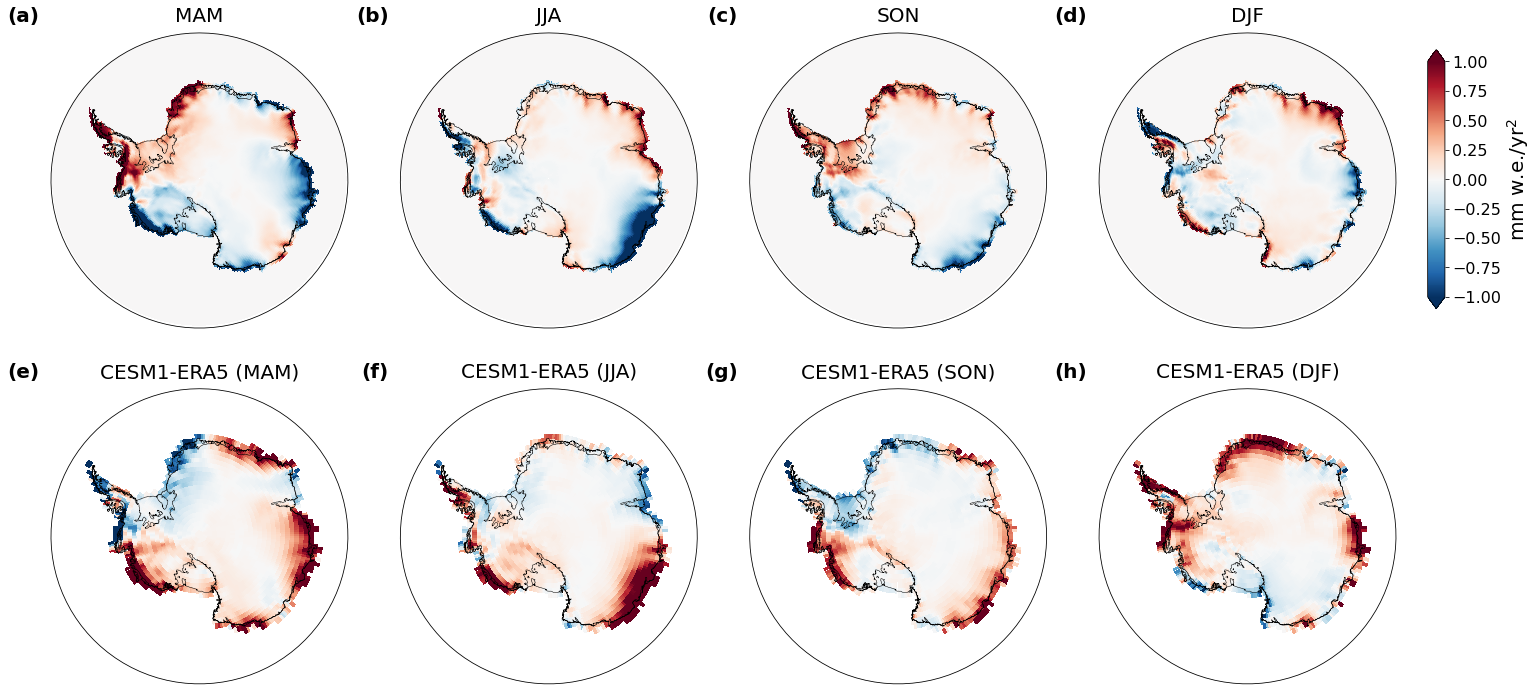

In [96]:
fig = plt.figure(figsize = (24,12))
gs=GridSpec(2,4)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax2 = plt.subplot(gs[0,1],projection=crs_sp)
ax3 = plt.subplot(gs[0,2],projection=crs_sp)
ax4 = plt.subplot(gs[0,3],projection=crs_sp)
im = plot_seasonal_plots(era_lat,era_lon, era_trend_mam, era_trend_jja, era_trend_son, era_trend_djf, 'RdBu_r', -1, 1, [ax1, ax2, ax3, ax4], -60)
ax1.set_title('MAM', fontsize = 20)
ax1.text(-0.05, 1.1, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax2.set_title('JJA', fontsize = 20)
ax2.text(-0.05, 1.1, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax3.set_title('SON', fontsize = 20)
ax3.text(-0.05, 1.1, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax4.set_title('DJF', fontsize = 20)
ax4.text(-0.05, 1.1, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax5 = plt.subplot(gs[1,0],projection=crs_sp)
ax6 = plt.subplot(gs[1,1],projection=crs_sp)
ax7 = plt.subplot(gs[1,2],projection=crs_sp)
ax8 = plt.subplot(gs[1,3],projection=crs_sp)
im = plot_seasonal_plots(lat,new_lon, era_mam_bias, era_jja_bias, era_son_bias, era_djf_bias, 'RdBu_r', -1, 1, [ax5, ax6, ax7, ax8], -60)
ax5.set_title('CESM1-ERA5 (MAM)', fontsize = 20)
ax5.text(-0.05, 1.1, '(e)', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax6.set_title('CESM1-ERA5 (JJA)', fontsize = 20)
ax6.text(-0.05, 1.1, '(f)', transform=ax6.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax7.set_title('CESM1-ERA5 (SON)', fontsize = 20)
ax7.text(-0.05, 1.1, '(g)', transform=ax7.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax8.set_title('CESM1-ERA5 (DJF)', fontsize = 20)
ax8.text(-0.05, 1.1, '(h)', transform=ax8.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')




cbar_ax = fig.add_axes([0.92, 0.56, 0.01, 0.3])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label=f'mm w.e./yr$^2$', size=20)
cb.ax.tick_params(labelsize=16)